In [102]:
from matplotlib.pylab import gca, figure, plot, subplot, title, xlabel, ylabel, xlim,show
from matplotlib.lines import Line2D
import src.segment as segment
import src.fit as fit
import matplotlib.pyplot as plt
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1)

In [103]:
import tsfresh
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, MinimalFCParameters

# Define

In [104]:
def draw_plot(data,plot_title):
    plot(range(len(data)),data,alpha=0.8,color='red')
    title(plot_title)
    xlabel("Samples")
    ylabel("Signal")
    xlim((0,len(data)-1))

def draw_segments(segments):
    ax = gca()
    for segment in segments:
        line = Line2D((segment[0],segment[2]),(segment[1],segment[3]))
        ax.add_line(line)

def draw_xvline(segments):
    for seg in segments:
        x0 = seg[0]
        plt.axvline(x=x0)
        
def draw_approximate_line(ax_set):
    fig, axs = plt.subplots(1,1, figsize=(25, 5))
    x0,y0,x1,y1 = ax_set[0]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for ax in ax_set:
        axs.plot((x1,ax[0]),(y1,ax[1]),ls='--',color='black',alpha=0.5)
        x0,y0,x1,y1 = ax
        axs.plot((x0,x1),(y0,y1),alpha=1,color=random.choice(colors))
    plt.show();

## Những segment có F1 > 0.5 thì coi như detect được

In [105]:
def get_anomaly_segment(line_segments):
    distance = [line_segments[0][3] - line_segments[1][1]]
    for i in range(1,len(line_segments)-1):
        left_distance = line_segments[i][1] - line_segments[i-1][3]
        right_distance = line_segments[i][3] - line_segments[i+1][1]
        dis = abs(left_distance + right_distance)
        distance.append(dis)
    last_dis = line_segments[len(line_segments)-1][1] - line_segments[len(line_segments)-2][3]
    distance.append(last_dis)
    return line_segments[distance.index(max(distance))]
def metrics(data,anomaly_idx,anomaly_segment):
    predict_index = np.arange(anomaly_segment[0],anomaly_segment[2],1)
    
    anomaly = np.zeros(data.shape[0])
    pred = np.zeros(data.shape[0])
    anomaly[anomaly_idx] = 1
    pred[predict_index] = 1
    
    tp = sum((a == 1 and p == 1) for a, p in zip(anomaly, pred))
    fp = sum((a == 0 and p == 1) for a, p in zip(anomaly, pred))
    fn = sum((a == 1 and p == 0) for a, p in zip(anomaly, pred))
    tn = sum((a == 0 and p == 0) for a, p in zip(anomaly, pred))
    
    accuracy = (tp + tn) / len(anomaly)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    result ={'Metrics':['Accuracy' ,'Precision','Recall','F1-score' ],
             'Score':[accuracy,precision, recall, f1]}
    result = pd.DataFrame(result)
    display(result.T)
    return accuracy,precision,recall,f1

# Data

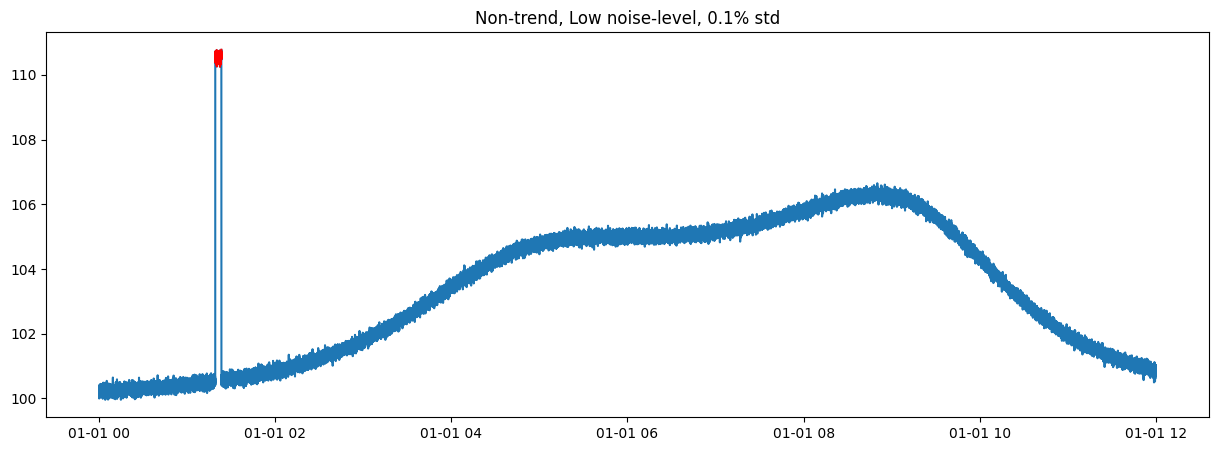

In [106]:
num_datapoints = 43200
time_index = pd.date_range(start='2024-01-01', periods=num_datapoints, freq='s')

mean_traffic = 100  
std_dev_traffic = 0.1

start_noise_period = 4750  
end_noise_period = 5000   
noise_level = 10

noise = np.zeros(num_datapoints)
noise[start_noise_period:end_noise_period] = np.full(250,noise_level)

x = np.arange(-2,2,step=9.259259259259259e-05)


traffic_data = np.random.normal(loc=mean_traffic, scale=std_dev_traffic, size=num_datapoints)
traffic_data_with_noise = traffic_data + noise
traffic_data_with_noise = traffic_data_with_noise + 1/(0.8*x**4-x**3+1)*5

network_traffic_df = pd.DataFrame( {'Traffic_Mbps': traffic_data_with_noise},index=time_index)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(network_traffic_df)
ax.plot(network_traffic_df[start_noise_period:end_noise_period],c='r')
ax.set_title('Non-trend, Low noise-level, 0.1% std');

In [7]:
anomaly_idx = list(np.arange(start_noise_period,end_noise_period))

# Feature

In [20]:
ts = pd.DataFrame(network_traffic_df['Traffic_Mbps'].iloc[:30000])
ts['id'] = 1

In [21]:
ts = ts.astype(np.float16)

In [22]:
extracted_feature = tsfresh.extract_features(ts,column_id='id',column_value='Traffic_Mbps')

Feature Extraction: 100%|███████████████████████████████████████████████████████████████| 1/1 [13:05<00:00, 785.68s/it]


In [23]:
extracted_relevant_feature = pd.DataFrame(extracted_feature,columns=['Traffic_Mbps__mean',
                                                                     'Traffic_Mbps__median',
                                                                     'Traffic_Mbps__variance',
                                                                     'Traffic_Mbps__standard_deviation',
                                                                     'Traffic_Mbps__absolute_sum_of_changes',
                                                                     'Traffic_Mbps__mean_abs_change',
                                                                     'Traffic_Mbps__kurtosis',
                                                                     'Traffic_Mbps__minimum',
                                                                     'Traffic_Mbps__maximum']).T
extracted_relevant_feature = extracted_relevant_feature.rename(columns={1: 'Traffic_Mbps'})
extracted_relevant_feature.index = ['mean','median','variance','standard_deviation','absolute_sum_of_changes','mean_abs_change',
                                      'kurtosis','minimum','maximum']

In [24]:
extracted_relevant_feature

,Traffic_Mbps
mean,103.250000
median,103.875000
variance,inf
standard_deviation,inf
absolute_sum_of_changes,3370.000000
mean_abs_change,0.112366
kurtosis,-0.695312
minimum,99.937500
maximum,110.812500


# Top-down

## Best

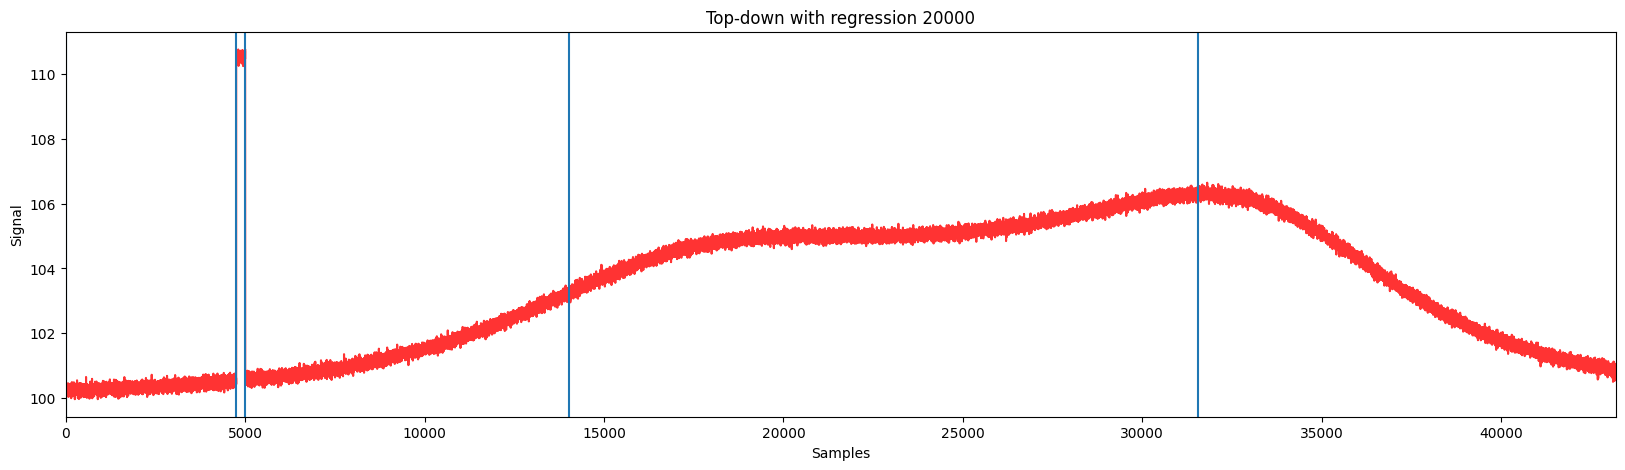

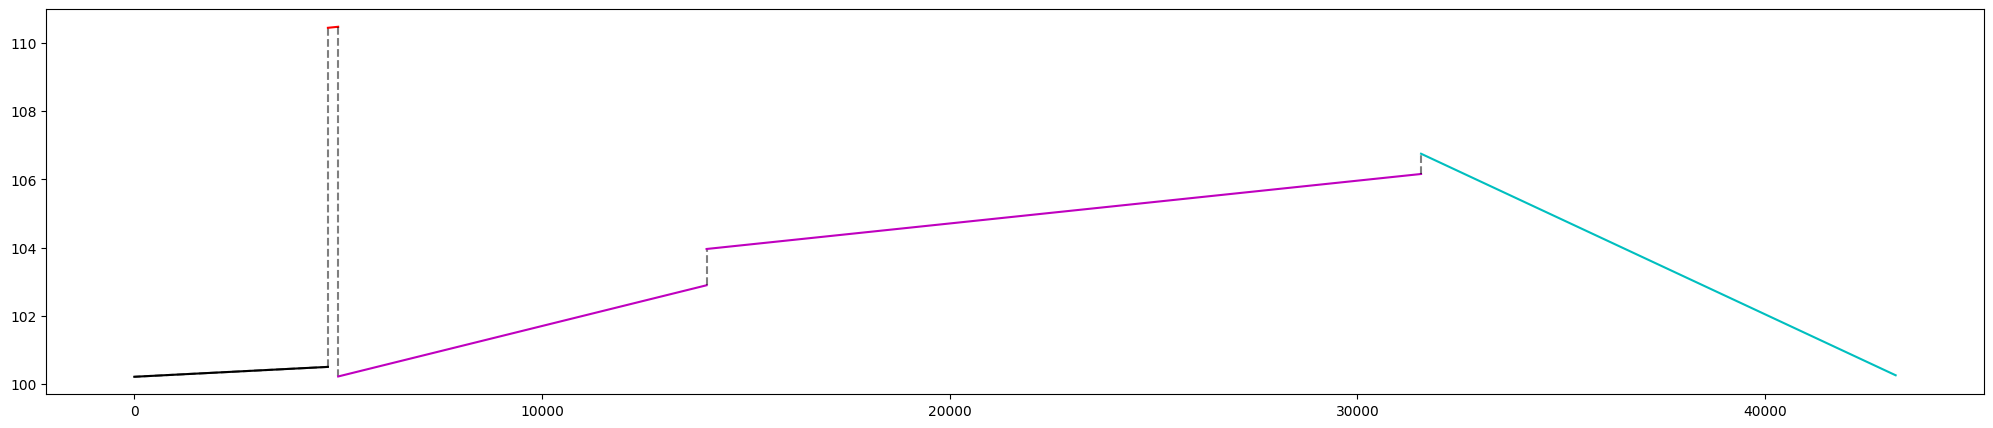

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999977,0.996016,1.0,0.998004


In [110]:
max_error = 20000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

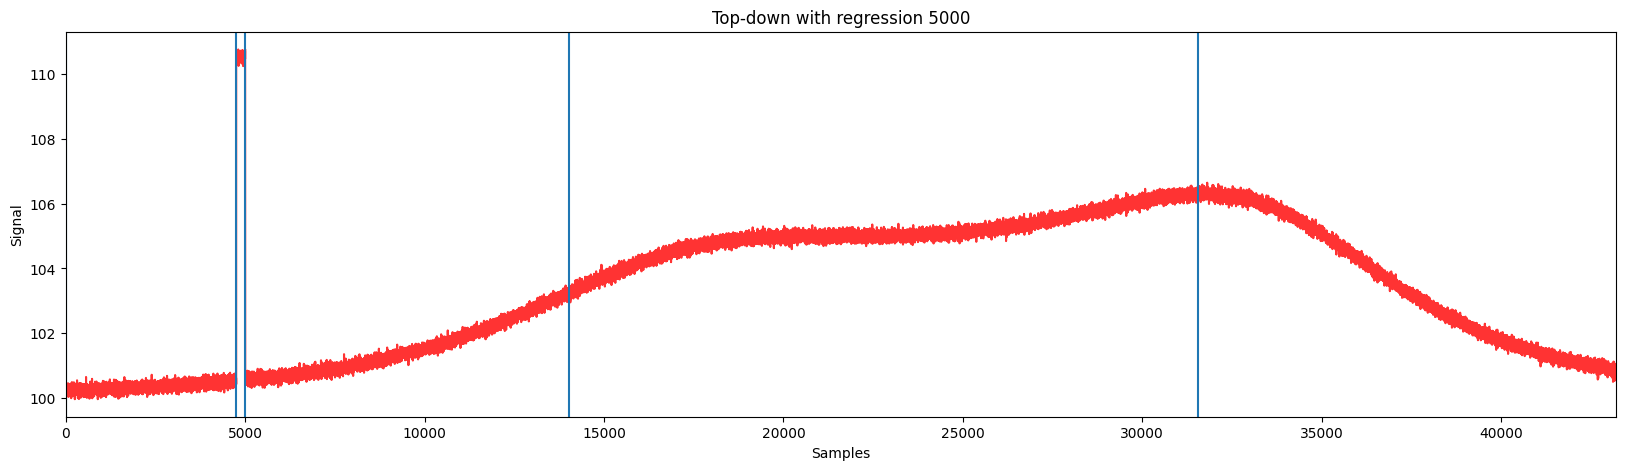

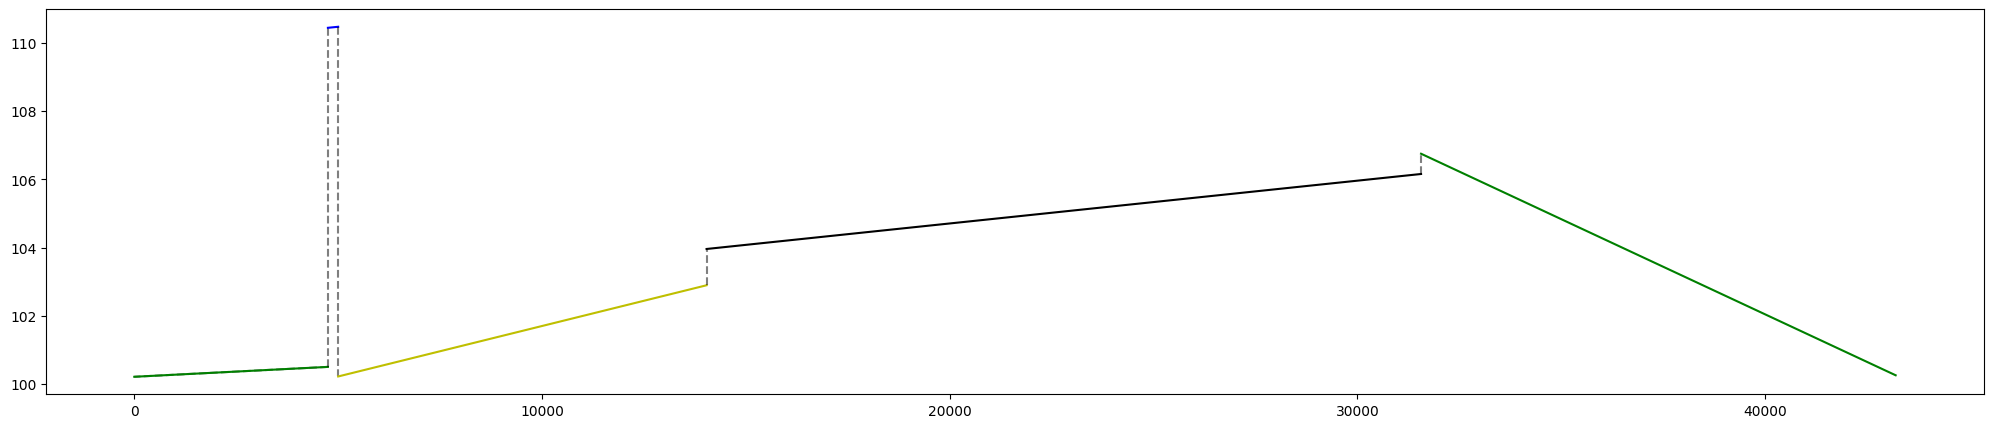

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999977,0.996016,1.0,0.998004


In [111]:
max_error = 5000
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

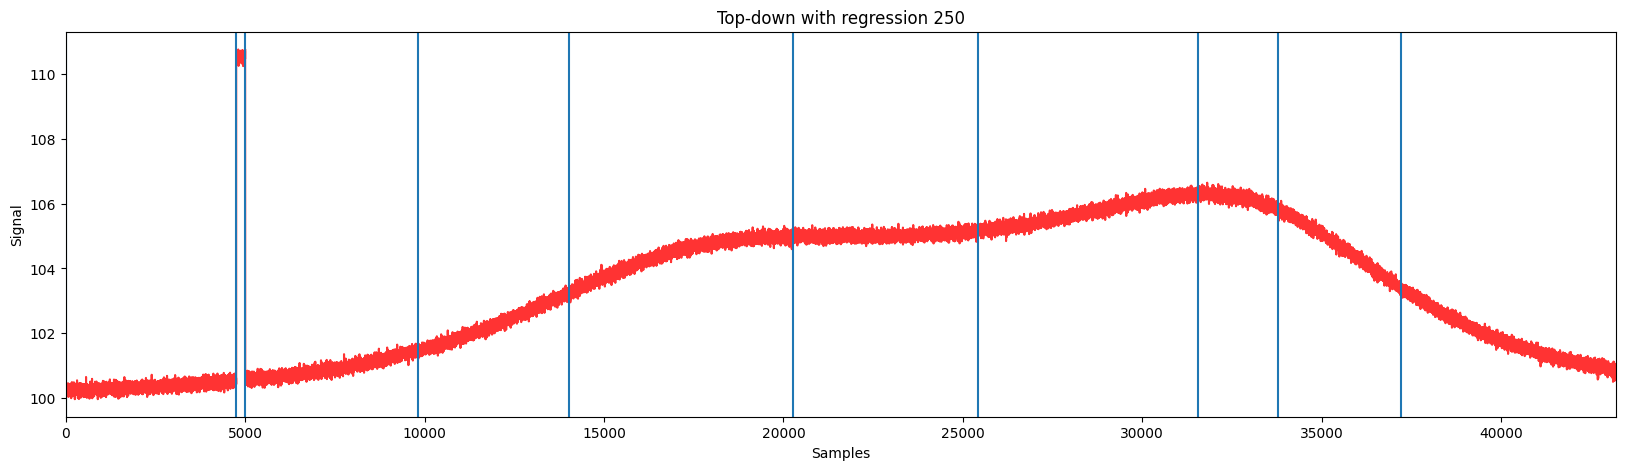

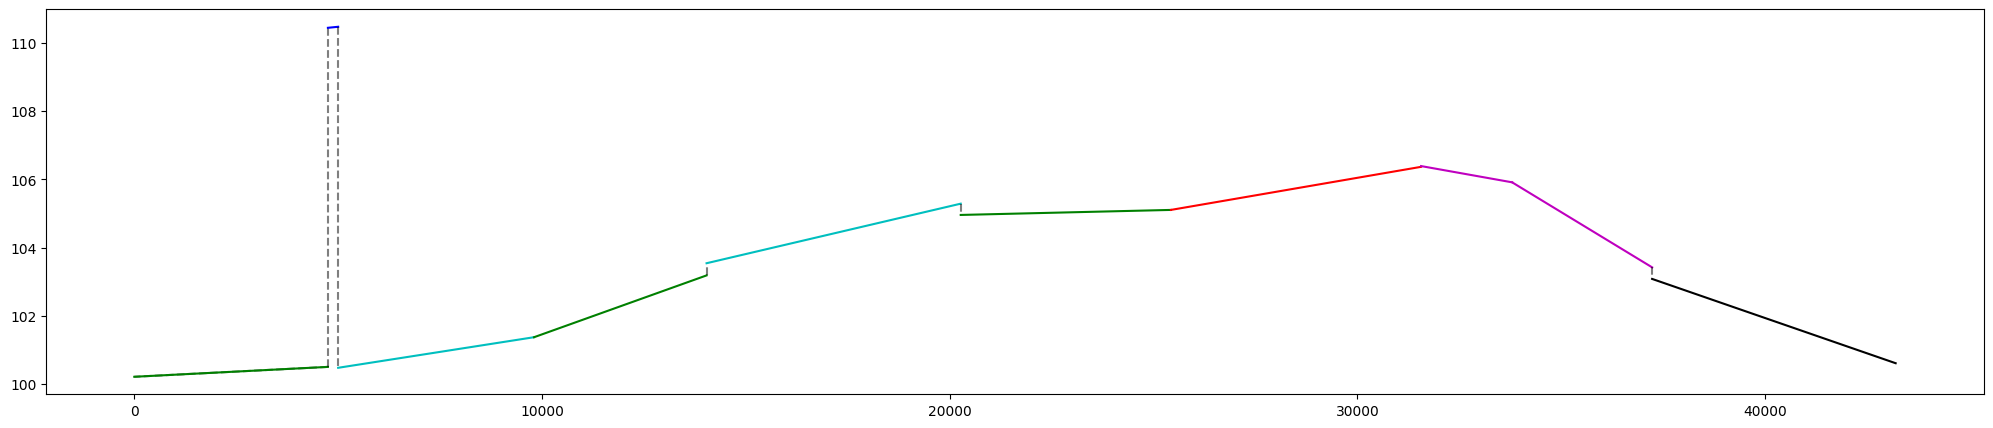

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999977,0.996016,1.0,0.998004


In [112]:
max_error = 250
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.topdownsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Top-down with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_topdown,pre_topdown,recall_topdown,f1_topdown = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [43]:
range_max_error_topdown = (100,20000)
best_Top_down = 7500
time_avg_Top_down = (9*60+15 + 6*60+47 + 6*60+41)/3

In [80]:
33.478/26.162

1.279642229187371

# Bottom-up

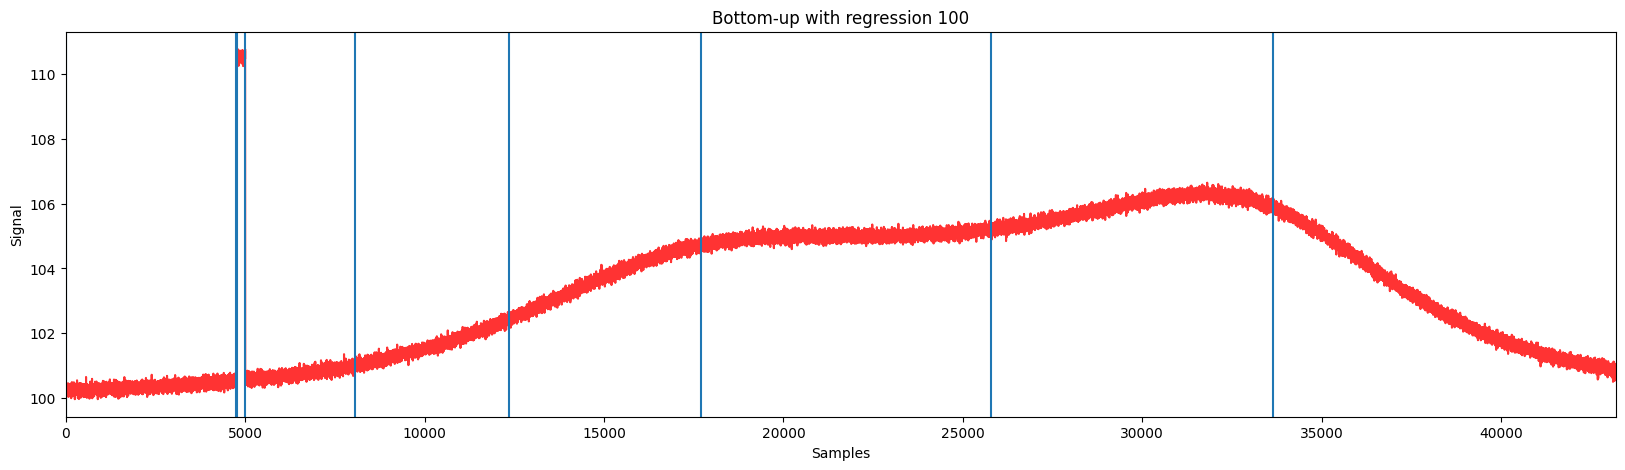

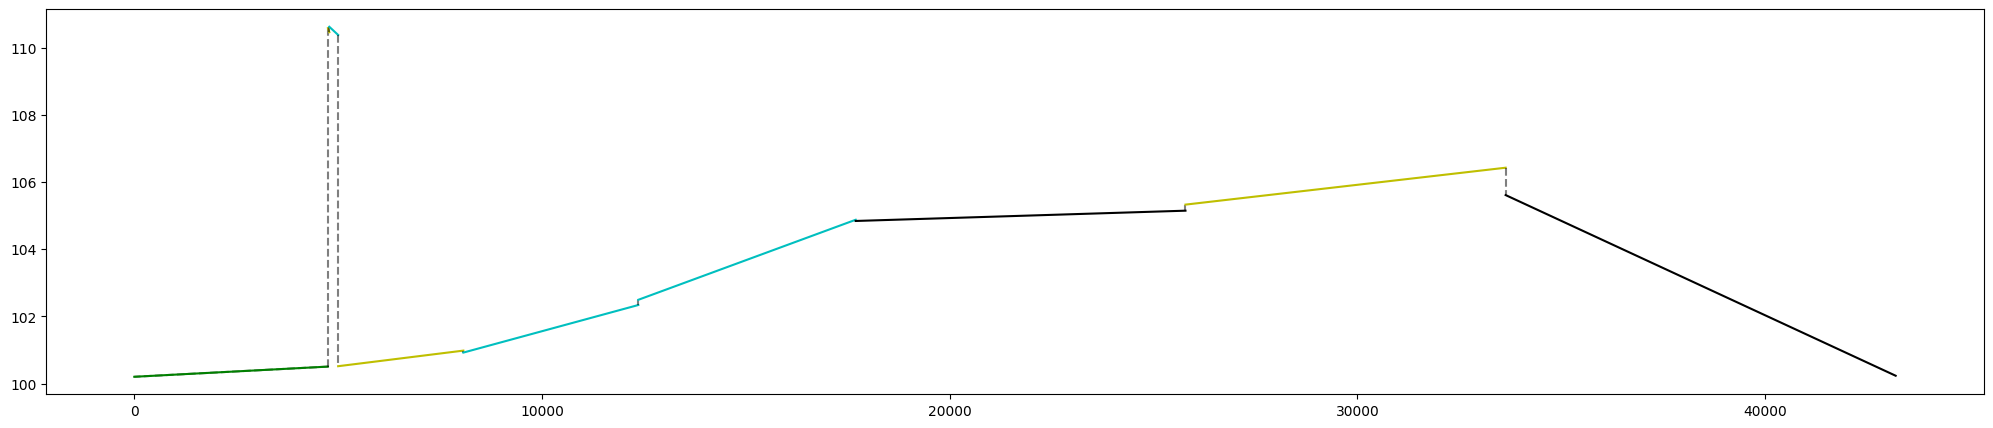

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [113]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

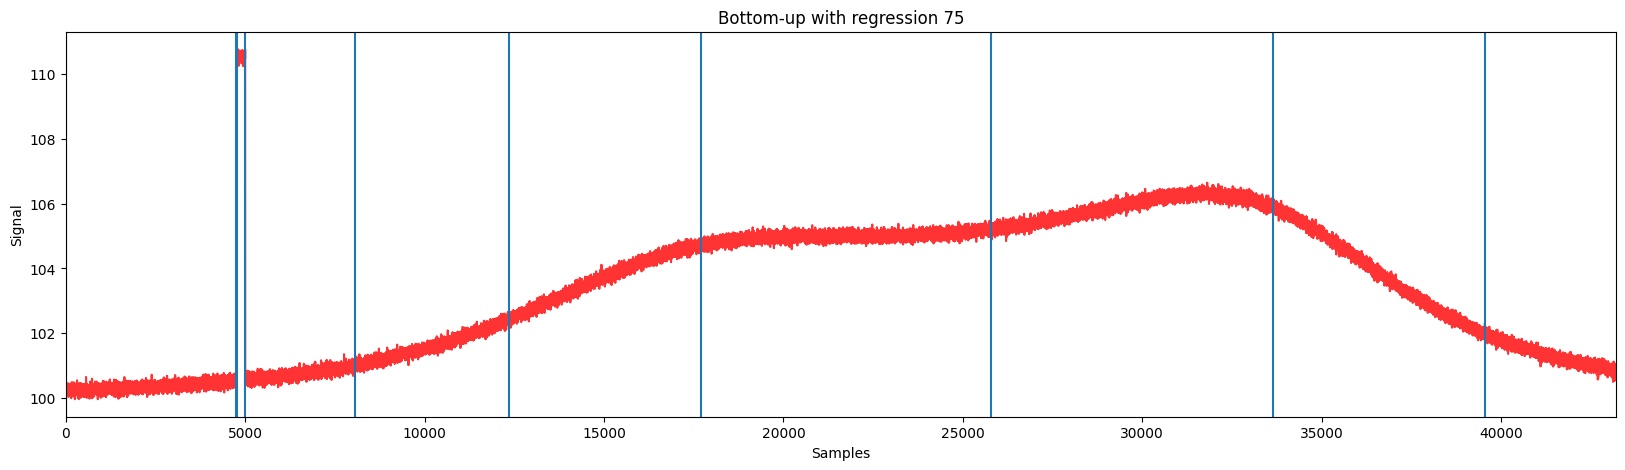

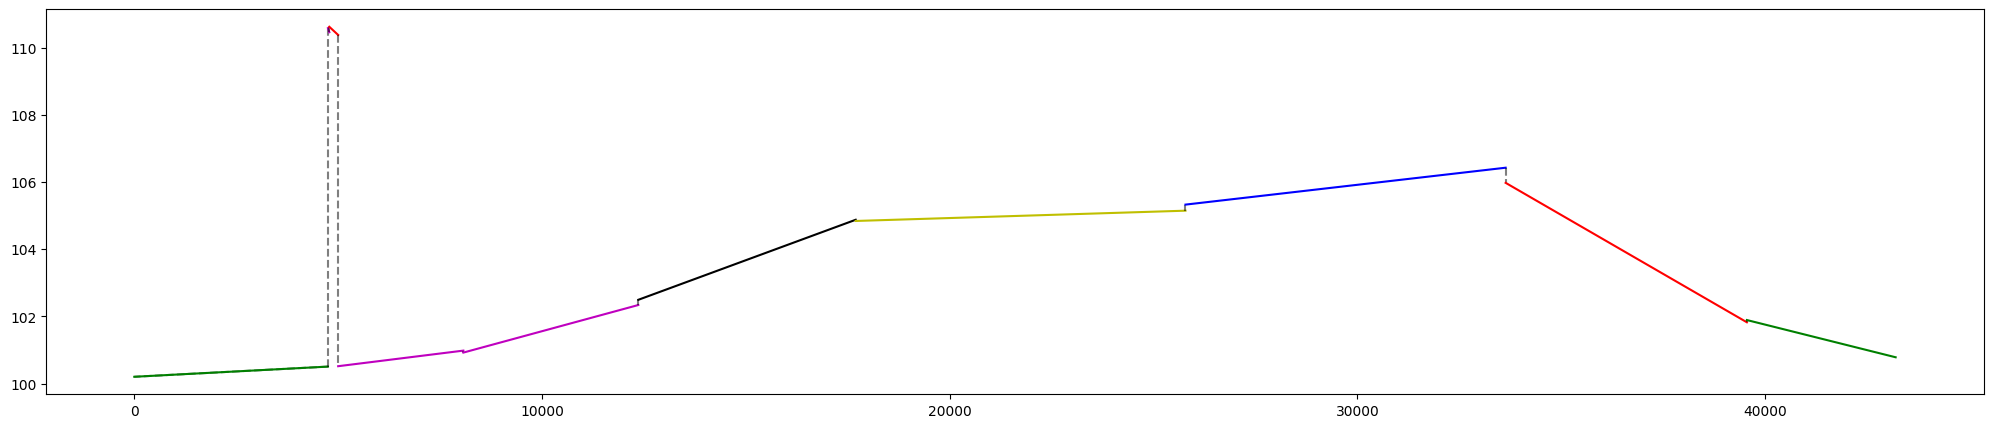

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [114]:
max_error = 75
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

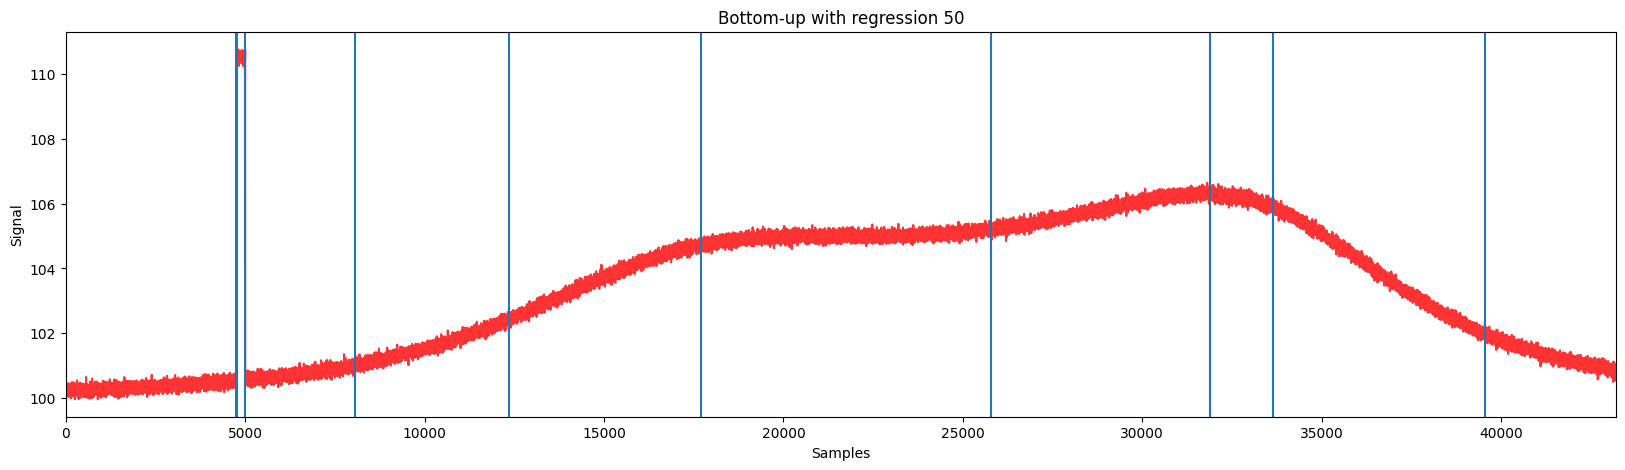

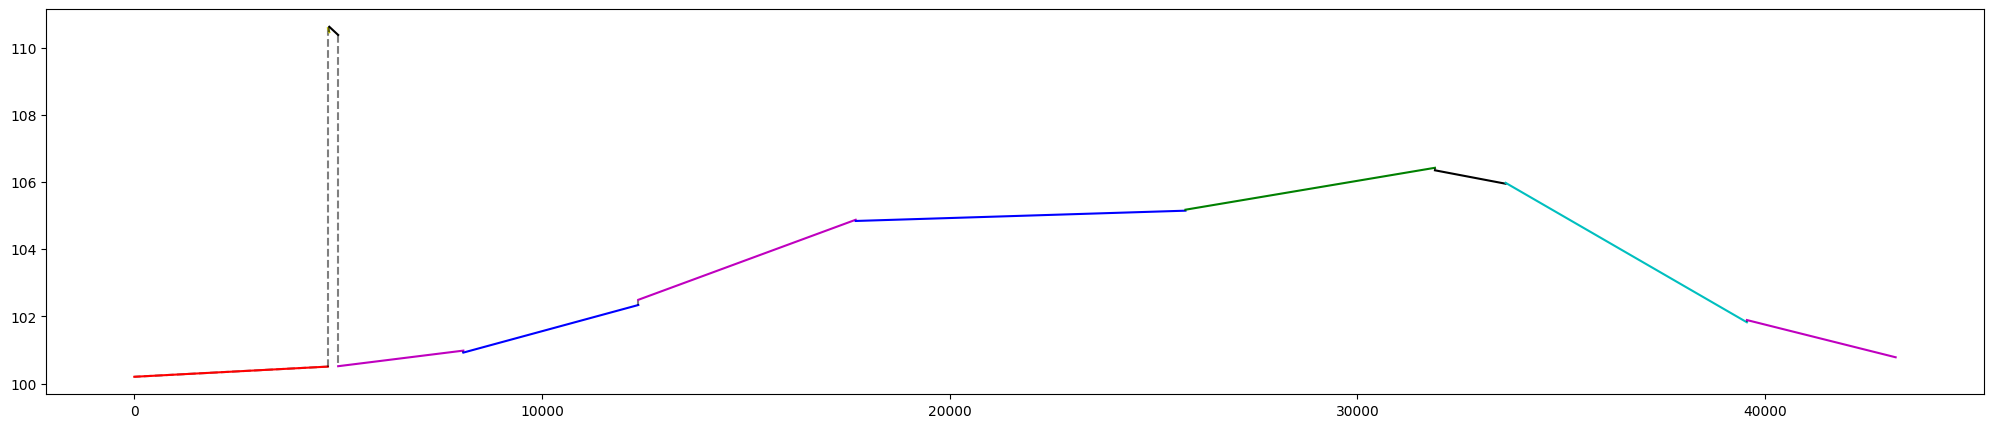

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [109]:
max_error = 50
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.bottomupsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Bottom-up with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_btu,pre_btu,recall_btu,f1_btu = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [81]:
range_max_error_bottomup = (50,100)
best_Bottom_up = 75
time_avg_Bottom_up = (77.4++83.7+75.3)/3

# Sliding window

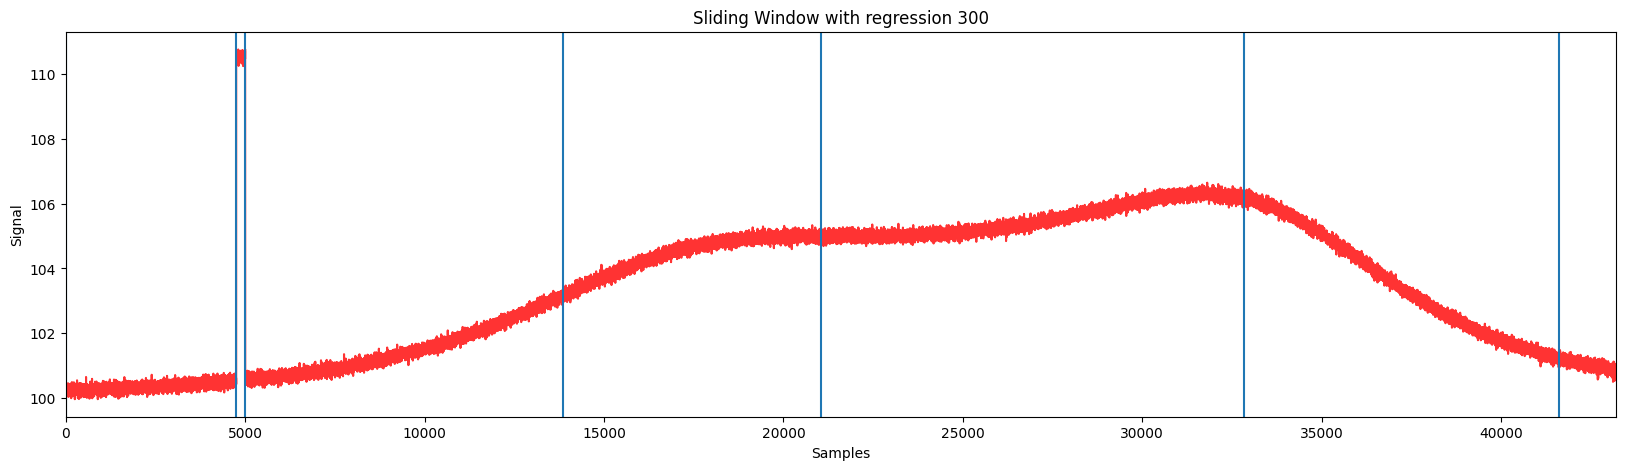

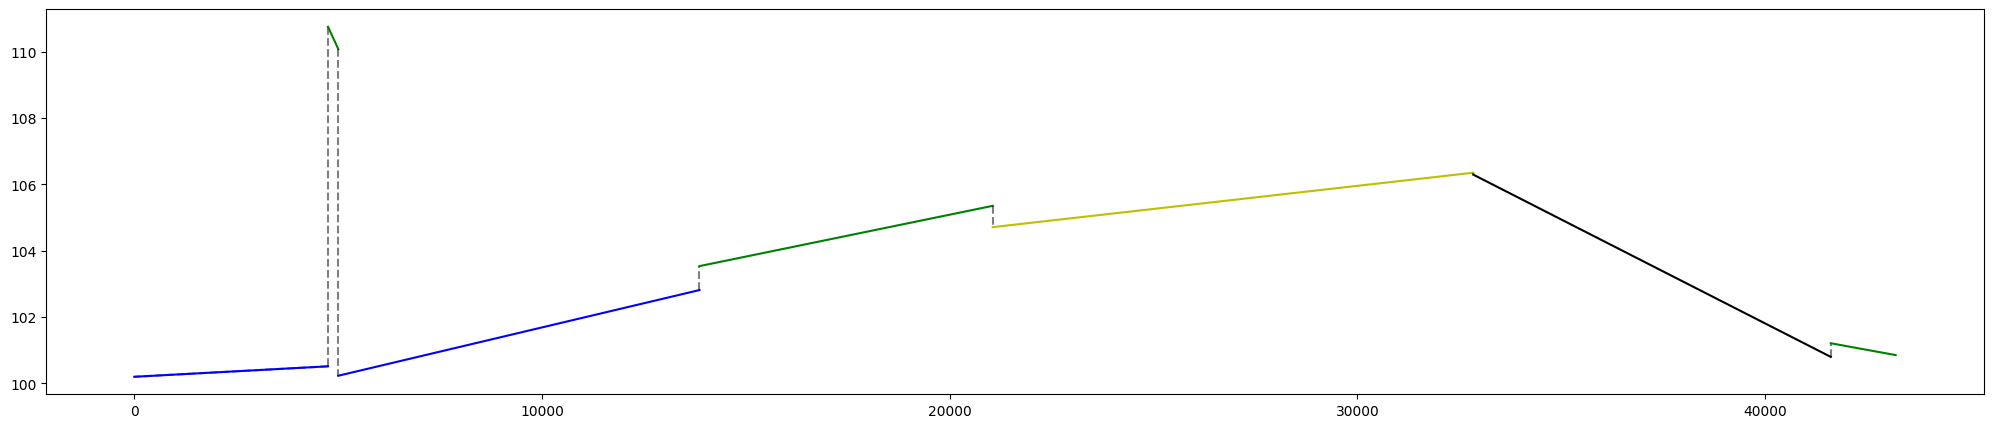

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999931,0.992032,0.996,0.994012


In [116]:
max_error = 300
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw= metrics(network_traffic_df,anomaly_idx,anomaly_segment)

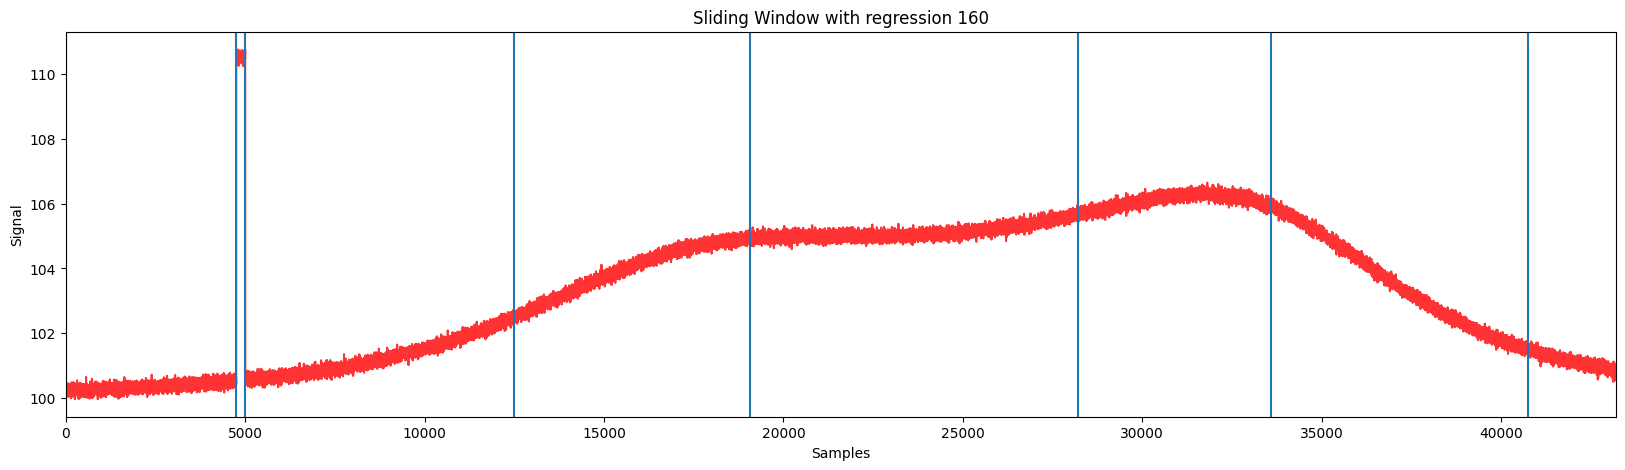

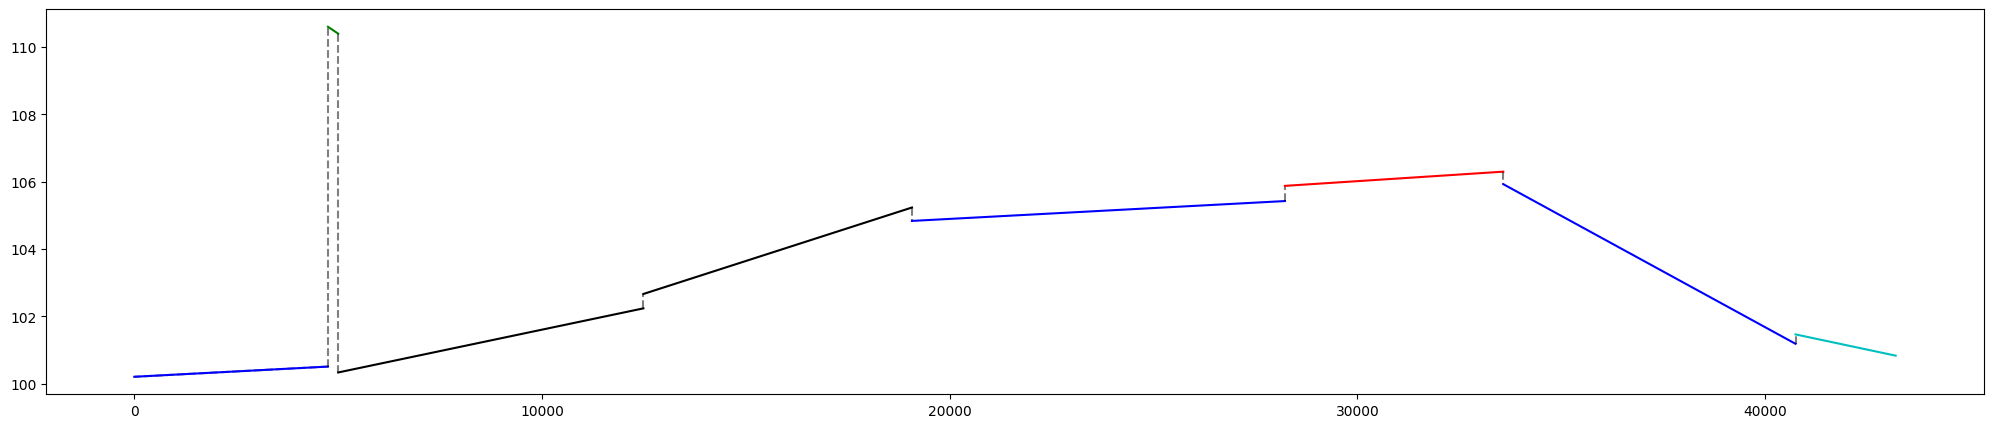

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,1.0,1.0,1.0,1.0


In [120]:
max_error = 160
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

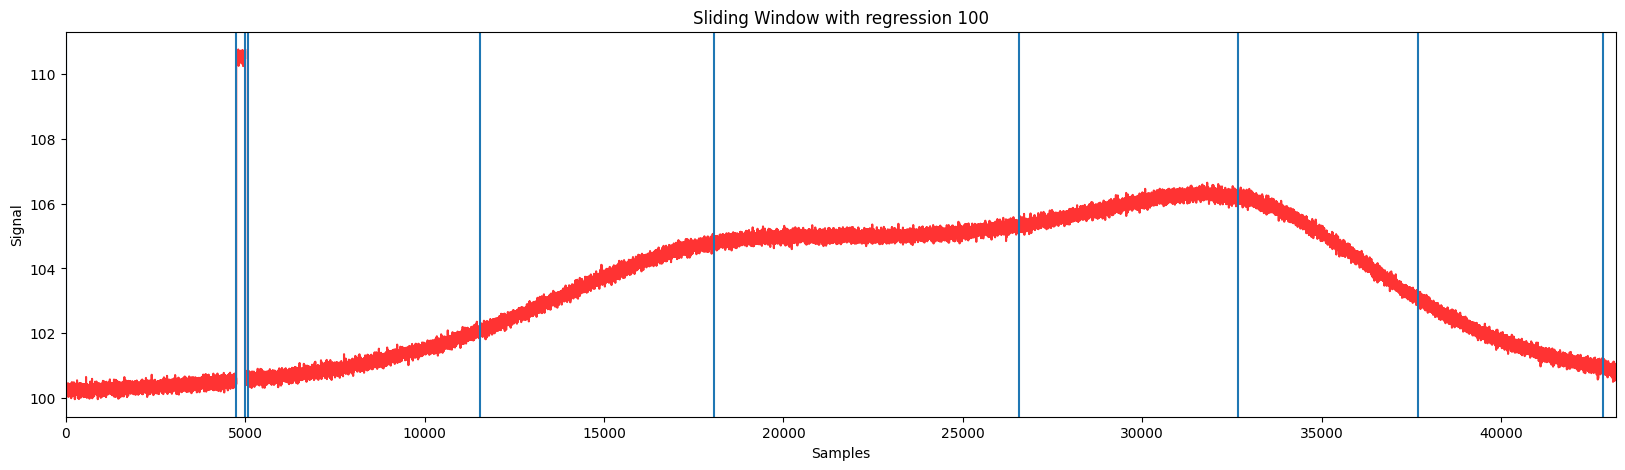

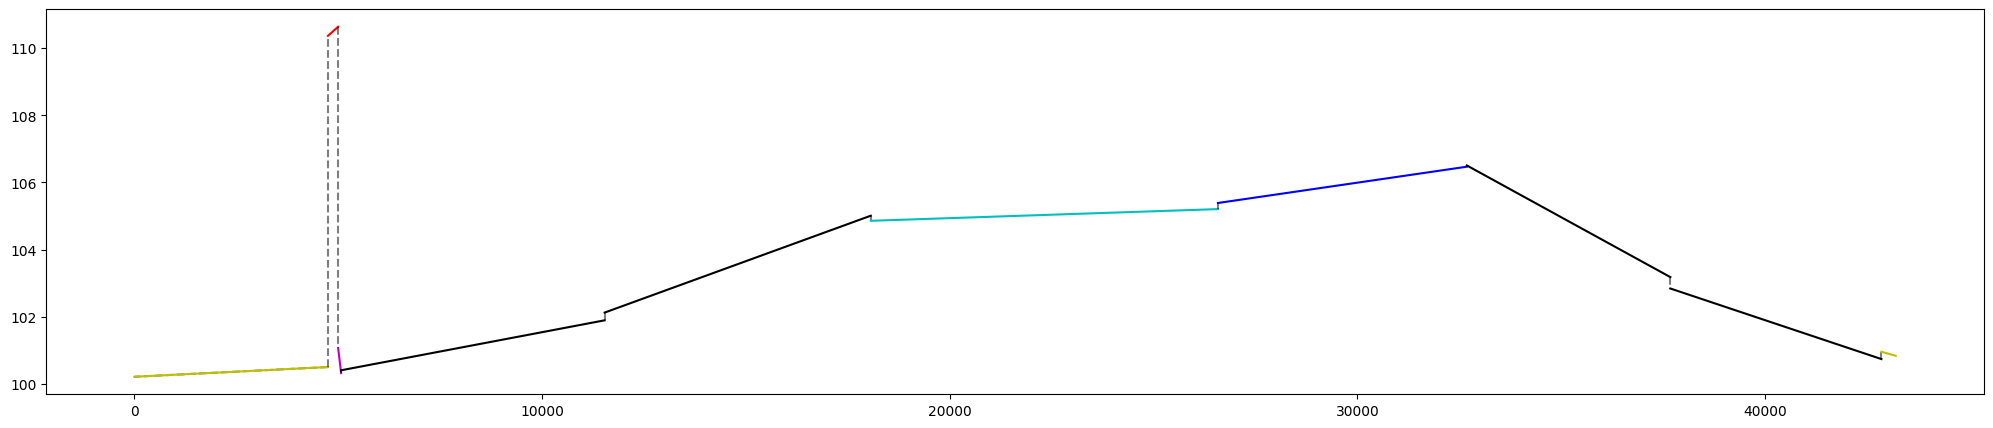

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999954,0.996,0.996,0.996


In [119]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.slidingwindowsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"Sliding Window with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_sldw,pre_sldw,recall_sldw,f1_sldw = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [86]:
range_max_error_sldw = (100,300)
best_sliding_window = 150
time_avg_sliding_window = (20+21.6+26.5)/3

# SWAB

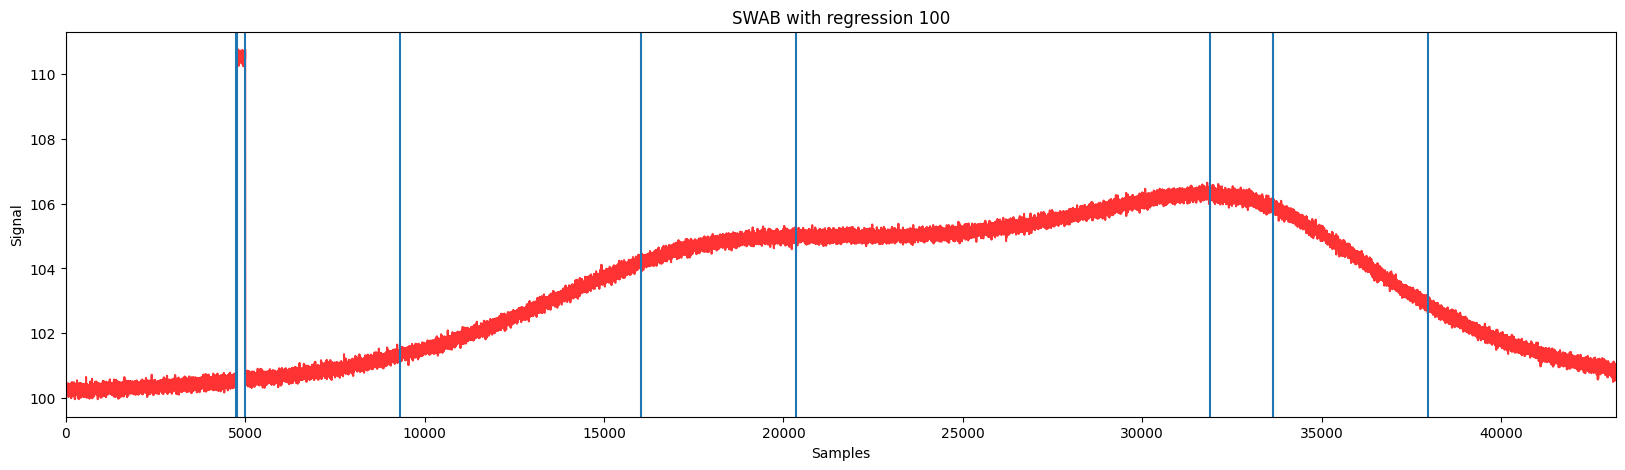

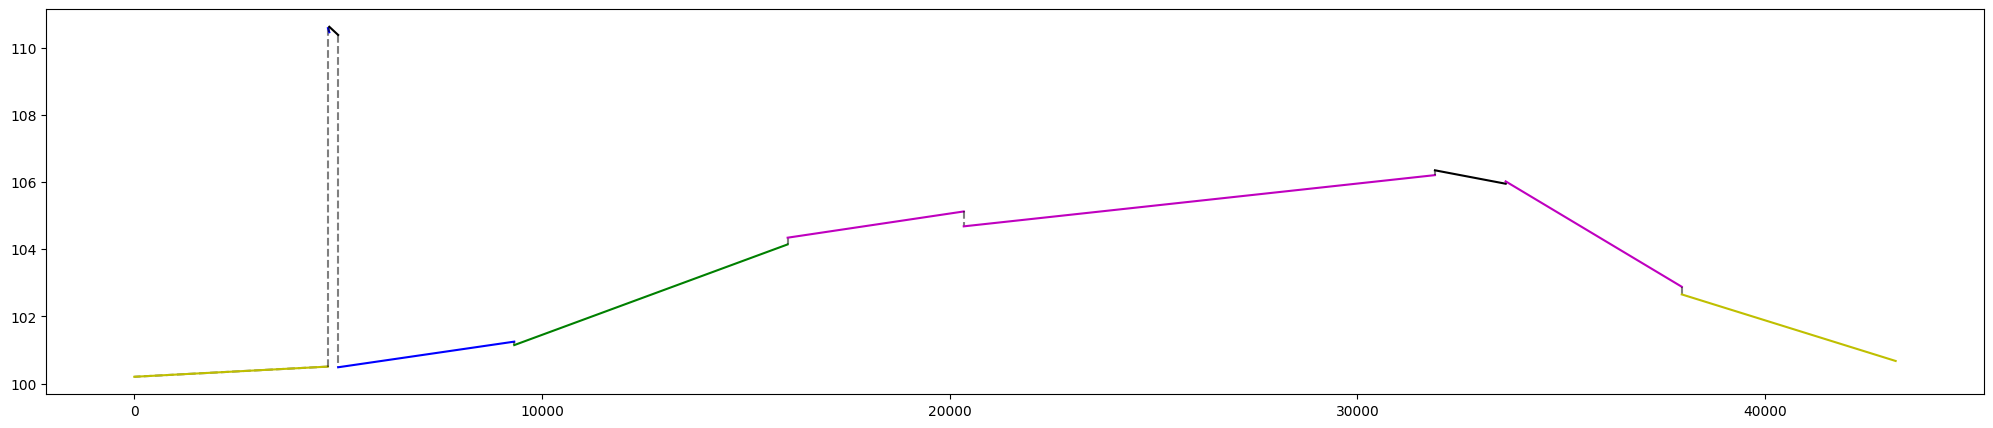

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [131]:
max_error = 100
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

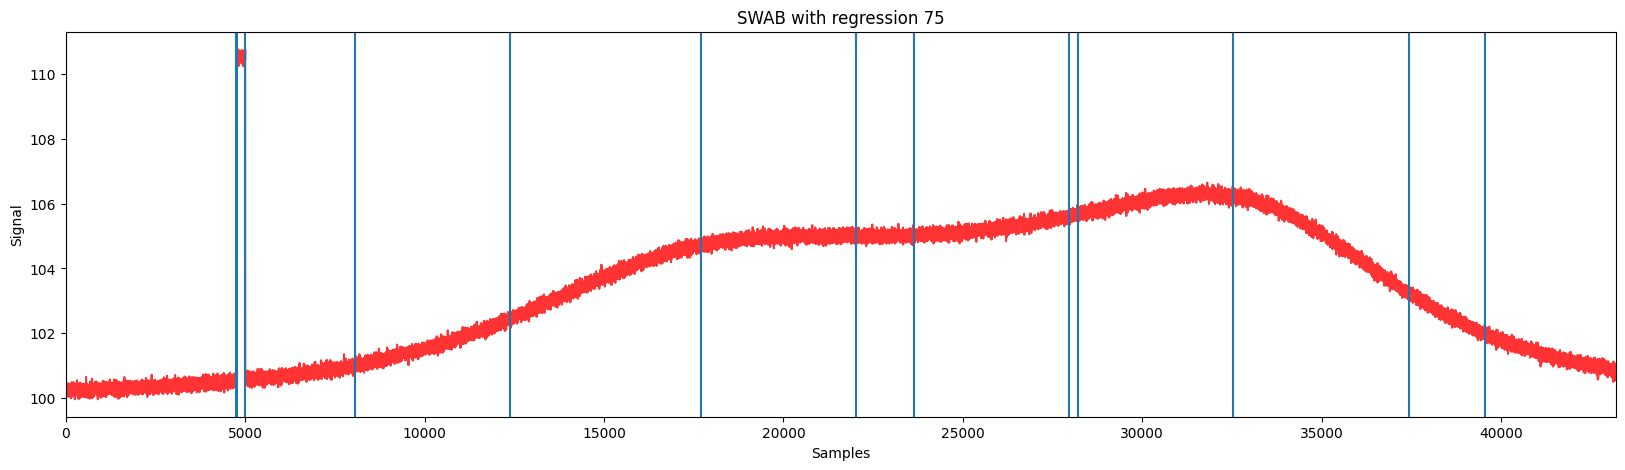

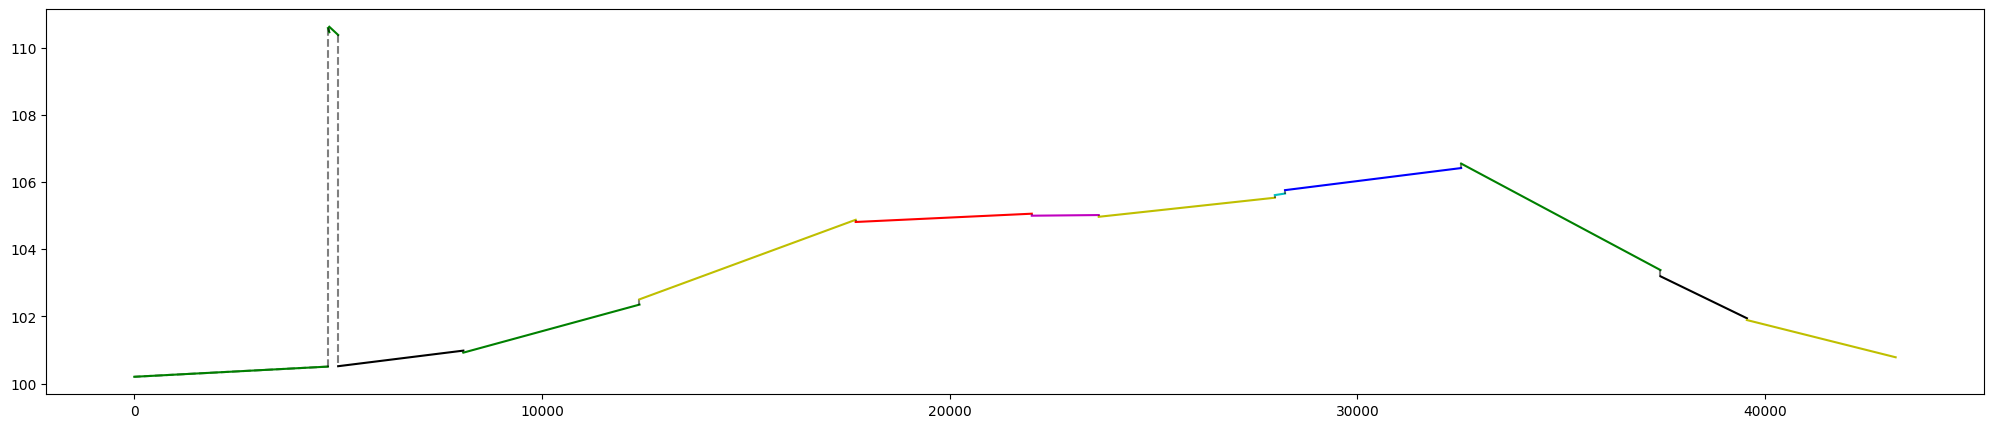

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [123]:
max_error = 75
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

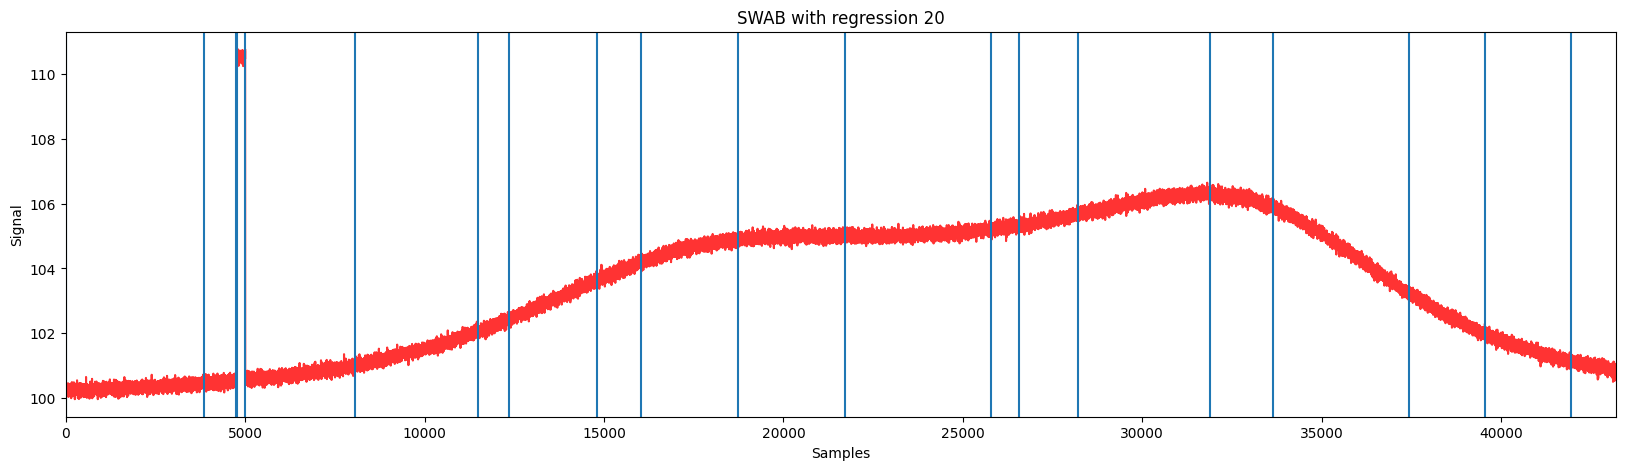

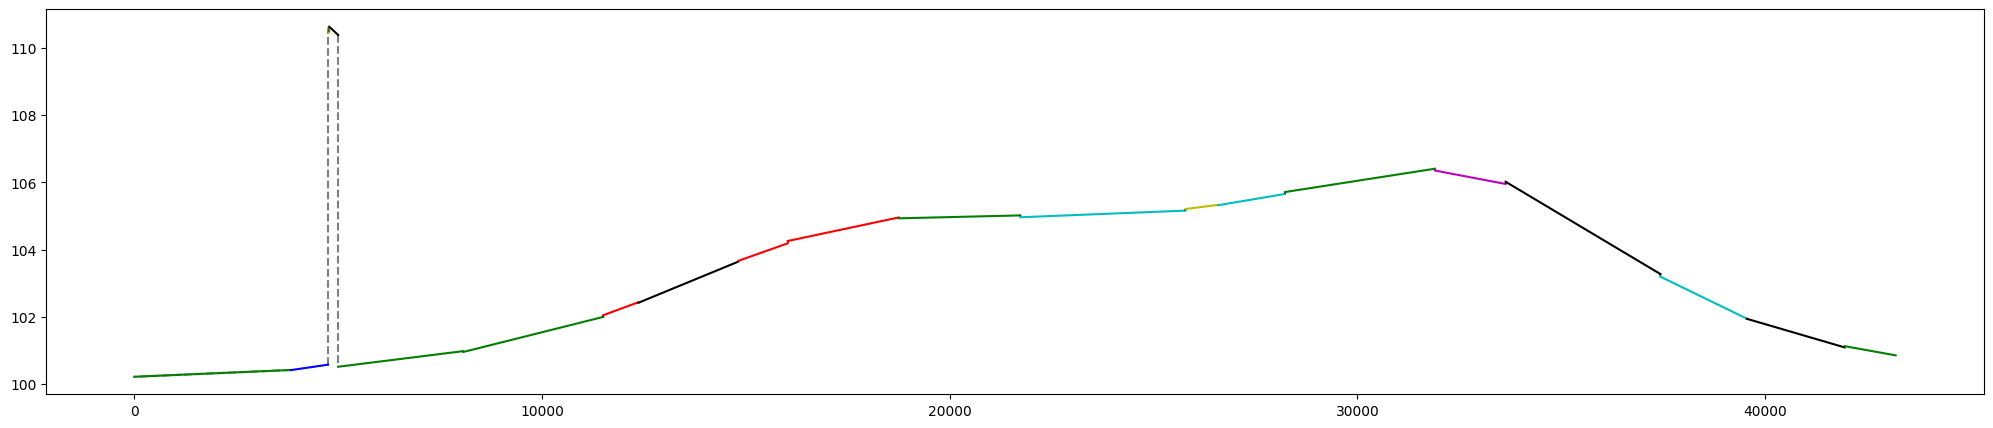

,0,1,2,3
Metrics,Accuracy,Precision,Recall,F1-score
Score,0.999236,1.0,0.868,0.929336


In [127]:
max_error = 20
data = list(network_traffic_df['Traffic_Mbps'].values)
ts_segments, line_segments = segment.get_ts_segments(segment.SWABsegment, data, fit.regression, fit.sumsquared_error, max_error)
figure(figsize=(20,5))
draw_plot(data,f"SWAB with regression {max_error}")
draw_xvline(line_segments)
draw_approximate_line(line_segments);
anomaly_segment = get_anomaly_segment(line_segments)
acc_swab,pre_swab,recall_swab,f1_swab = metrics(network_traffic_df,anomaly_idx,anomaly_segment)

In [132]:
range_max_error_swab = (20,100)
best_swab = 75
time_avg_swab = (99.5+69.84+53.6)/3

# Conclusion

In [134]:
data = {
    'Id' : [5,5,5,5],
    'Algorithm': ['Top-down', 'Bottom-up', 'Sliding-window','SWAB'],
    'min(max_error)': [range_max_error_topdown[0],range_max_error_bottomup[0], range_max_error_sldw[0],range_max_error_swab[0]],
    'max(max_error)': [range_max_error_topdown[1],range_max_error_bottomup[1],range_max_error_sldw[1],range_max_error_swab[1]],
    'Best': [best_Top_down, best_Bottom_up,best_sliding_window,best_swab],
    'Time Average(in range)': [time_avg_Top_down, time_avg_Bottom_up, time_avg_sliding_window,time_avg_swab],
    'Accuracy' : [acc_topdown,acc_btu,acc_sldw,acc_swab],
    'Precision' : [pre_topdown,pre_btu,pre_sldw,pre_swab],
    'Recall' : [recall_topdown,recall_btu,recall_sldw,recall_swab],
    'F1-score' : [f1_topdown,f1_btu,f1_sldw,f1_swab],
    'Rank' : [2,3,1,3]
}

conclusion_df = pd.DataFrame(data)
conclusion_df

,Id,Algorithm,min(max_error),max(max_error),Best,Time Average(in range),Accuracy,Precision,Recall,F1-score,Rank
0,5,Top-down,100,15000,7500,454.333333,0.999977,0.996016,1.000,0.998004,2
1,5,Bottom-up,50,100,75,78.800000,0.999236,1.000000,0.868,0.929336,3
2,5,Sliding-window,100,300,150,22.700000,1.000000,1.000000,1.000,1.000000,1
3,5,SWAB,20,100,75,74.313333,0.999236,1.000000,0.868,0.929336,3


# To exp

## Conclusion

In [135]:
old_conclusion_df = pd.read_csv('exp\Conclusion.csv')
add_df = conclusion_df.drop(columns='Rank')
conclusion_df = pd.concat([old_conclusion_df, add_df], ignore_index=True)
conclusion_df = conclusion_df.drop_duplicates()
conclusion_df.to_csv('exp\Conclusion.csv',index=False)

## Feature _ Maxerror

In [136]:
feature_max_error = pd.DataFrame(data=extracted_relevant_feature.T)
feature_max_error['id'] = 5
feature_max_error['Num_points'] = num_datapoints
feature_max_error['Min(max_error)_Top_down'] = range_max_error_topdown[0]
feature_max_error['Max(max_error)_Top_down'] = range_max_error_topdown[1]
feature_max_error['Min(max_error)_Bottom_up'] = range_max_error_bottomup[0]
feature_max_error['Max(max_error)_Bottom_up'] = range_max_error_bottomup[1]
feature_max_error['Min(max_error)_SLDW'] = range_max_error_sldw[0]
feature_max_error['Max(max_error)_SLDW'] = range_max_error_sldw[1]
feature_max_error['Min(max_error)_SWAB'] = range_max_error_swab[0]
feature_max_error['Max(max_error)_SWAB'] = range_max_error_swab[1]
feature_max_error['Best(max_error)_SWAB'] = best_Top_down
feature_max_error['Best(max_error)_SWAB'] = best_Bottom_up
feature_max_error['Best(max_error)_SWAB'] = best_sliding_window
feature_max_error['Best(max_error)_SWAB'] = best_swab

numpoints_column = feature_max_error.pop('Num_points')
feature_max_error.insert(0, 'Num_points', numpoints_column)
id_column = feature_max_error.pop('id')
feature_max_error.insert(0, 'id', id_column)

In [137]:
old_feat_df = pd.read_csv('exp\Feature__Maxerror.csv')
add_feat_df = feature_max_error
feat_df = pd.concat([old_feat_df, add_feat_df], ignore_index=True)
feat_df = feat_df.drop_duplicates()
feat_df.to_csv('exp\Feature__Maxerror.csv',index=False)
feat_df

,id,Num_points,mean,median,variance,standard_deviation,absolute_sum_of_changes,mean_abs_change,kurtosis,minimum,maximum,Min(max_error)_Top_down,Max(max_error)_Top_down,Min(max_error)_Bottom_up,Max(max_error)_Bottom_up,Min(max_error)_SLDW,Max(max_error)_SLDW,Min(max_error)_SWAB,Max(max_error)_SWAB,Best(max_error)_SWAB
0,2,8640,102.151881,100.286884,212.017664,14.560826,95822.993645,11.091908,4.776042,62.598994,181.709748,50000,350000,30000,90000,35000,150000,30000,90000,60000
1,1,8640,104.621483,100.014344,442.227086,21.029196,4986.149682,0.577167,16.640276,98.129950,201.585487,50,850000,50,10100,10000,550000,50,12500,4975
2,3,8640,105.479853,104.740898,27.596187,5.253207,4896.920656,0.566839,11.940497,98.632061,132.271730,4000,57500,100,625,2500,25000,100,600,350
3,4,8640,101.822061,101.317681,3.021211,1.738163,977.164373,0.113111,1.649976,99.734227,110.681462,1400,5000,0,100,400,1400,0,100,50
4,6,8640,104.766749,113.999449,5159.711223,71.831130,10003.014053,1.157890,-1.502673,-5.871039,202.953165,90000,5000000,25000,35000,40000,1000000,98,102,100
5,7,8640,102.895171,101.124826,13.689025,3.699868,975.726054,0.112944,-0.675163,94.723825,110.220648,30,450,2,25,30,140,2,25,10
6,8,8640,99.998457,99.999819,0.185628,0.430846,971.447477,0.112449,1.043627,98.715405,101.216021,5,30,1,4,1,10,1,4,2
7,9,8640,99.951207,99.996803,0.240128,0.490029,217.890120,0.025222,0.123460,98.939642,101.066830,500,1000,30,200,43,47,30,85,50
8,10,8640,100.005260,100.001092,0.207109,0.455093,221.400262,0.025628,0.444073,98.938823,101.061042,40,60,30,700,40,60,400,100000,50000
9,5,43200,103.250000,103.875000,inf,inf,3370.000000,0.112366,-0.695312,99.937500,110.812500,100,15000,50,100,100,300,20,100,75
